<a href="https://colab.research.google.com/github/Shambhavikr28/Technical-Indicators/blob/Tech_Ind_Task2/Technical_Indicators(Task_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
def calc_ema(price_data, window):
    return price_data['Close'].ewm(span=window, adjust=False).mean()

In [ ]:
def RSIcalc(price_data, window):
 final_price_data=price_data['Close'].diff(1)
 gain=final_price_data.where(final_price_data>0,0)
 loss=-final_price_data.where(final_price_data<0,0)
 avg_gain=gain.rolling(window=14).mean()
 avg_loss=loss.rolling(window=14).mean()
 rs=avg_gain/avg_loss
 RSIcalc=100-(100/(1+rs))
 return RSIcalc

In [ ]:
def signals(price_data, calc_ema_window, RSIcalc_window, RSIcalc_overbought, RSIcalc_oversold):
    signals = pd.DataFrame(index=price_data.index)
    signals['calc_ema'] = calc_ema(price_data, calc_ema_window)
    signals['RSIcalc'] = RSIcalc(price_data, RSIcalc_window)
    signals['Signal'] = 0
    signals['Signal'][signals['calc_ema'] > price_data['Close']] = 1  # Long signal
    signals['Signal'][signals['calc_ema'] < price_data['Close']] = -1  # Short signal
    signals['Signal'][(signals['RSIcalc'] > RSIcalc_overbought) & (signals['Signal'] == 1)] = 0  # Exit long
    signals['Signal'][(signals['RSIcalc'] < RSIcalc_oversold) & (signals['Signal'] == -1)] = 0  # Exit short
    return signals

In [ ]:
ticker='IFCI.NS'
start='2019-01-28'
end='2024-01-24'
price_data=yf.download(ticker,start=start,end=end)
calc_ema_window=20
RSIcalc_window=14
RSIcalc_overbought=70
RSIcalc_oversold=30
signals=signals(price_data,calc_ema_window,RSIcalc_window,RSIcalc_overbought,RSIcalc_oversold)
print(signals)

[*********************100%%**********************]  1 of 1 completed

             calc_ema    RSIcalc  Signal
Date                                    
2019-01-28  13.900000        NaN       0
2019-01-29  13.904762        NaN      -1
2019-01-30  13.875737        NaN       1
2019-01-31  13.849476        NaN       1
2019-02-01  13.816193        NaN       1
...               ...        ...     ...
2024-01-17  29.779379  70.588244      -1
2024-01-18  29.938486  67.692332      -1
2024-01-19  30.144345  72.142870      -1
2024-01-22  30.330597  74.814832      -1
2024-01-23  31.251493  88.194461      -1

[1233 rows x 3 columns]



<ipython-input-30-3d9f583b380d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][signals['calc_ema'] > price_data['Close']] = 1  # Long signal
<ipython-input-30-3d9f583b380d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][signals['calc_ema'] < price_data['Close']] = -1  # Short signal
<ipython-input-30-3d9f583b380d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][(signals['RSIca

In [ ]:
def backtest(price_data,signals,initial_capital=100001,compound=True):
    positions = pd.DataFrame(index=price_data.index)
    positions['Position'] = signals['Signal']
    positions['Stock'] = 100 * positions['Position'] #with the assumption of 100 shares
    portfolio = positions.multiply(price_data['Close'], axis=0)
    pos_diff = positions.diff()
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * price_data['Close']).cumsum()
    portfolio['Total'] = portfolio['Stock'] + portfolio['Cash']
    portfolio['Returns'] = portfolio['Total'].pct_change()
    if compound:
        portfolio['Returns'] = (1 + portfolio['Returns']).cumprod() - 1
    return portfolio


In [ ]:
portfolio=backtest(price_data,signals)
print(portfolio)

             Position        Stock           Cash          Total  Returns
Date                                                                     
2019-01-28   0.000000     0.000000            NaN            NaN      NaN
2019-01-29 -13.950000 -1394.999981  101395.999981  100001.000000      NaN
2019-01-30  13.600000  1360.000038   98675.999905  100035.999943  0.00035
2019-01-31  13.600000  1360.000038   98675.999905  100035.999943  0.00035
2019-02-01  13.500000  1350.000000   98675.999905  100025.999905  0.00025
...               ...          ...            ...            ...      ...
2024-01-17 -31.549999 -3154.999924  100775.999952   97621.000029 -0.02380
2024-01-18 -31.450001 -3145.000076  100775.999952   97630.999876 -0.02370
2024-01-19 -32.099998 -3209.999847  100775.999952   97566.000105 -0.02435
2024-01-22 -32.099998 -3209.999847  100775.999952   97566.000105 -0.02435
2024-01-23 -40.000000 -4000.000000  100775.999952   96775.999952 -0.03225

[1233 rows x 5 columns]


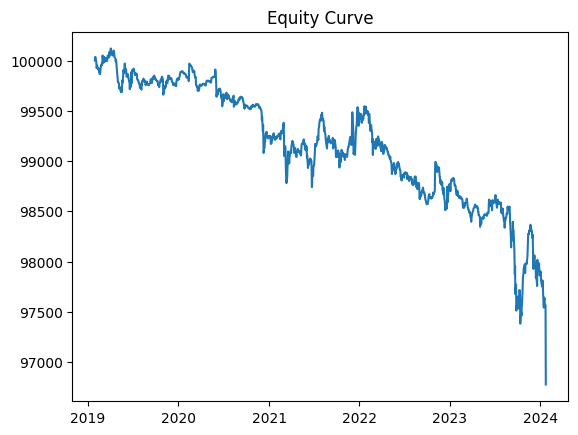

In [ ]:
plt.plot(portfolio['Total'])
plt.title(label='Equity Curve')
plt.show()

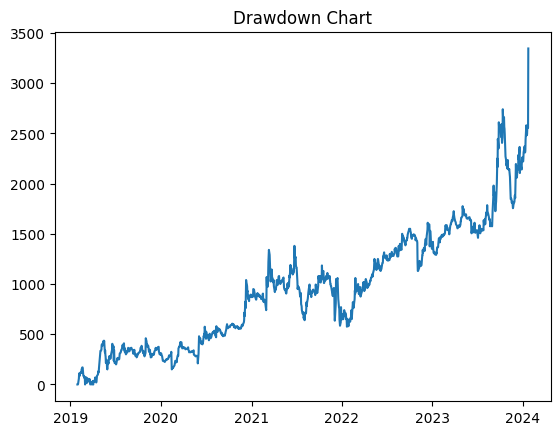

In [ ]:
plt.plot(portfolio['Total'].cummax() - portfolio['Total'])
plt.title(label='Drawdown Chart')
plt.show()

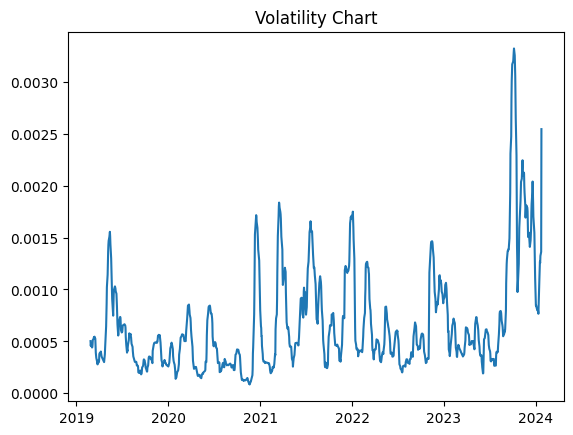

In [ ]:
plt.plot(portfolio['Returns'].rolling(window=20).std())
plt.title(label='Volatility Chart')
plt.show()